## ECON622 Final Project
### Thomas Chan

#### Project Outline

In Guerre, Perrigne and Vuong (2000), a two step kernel based estimator was derived to estimate the latent density of private values using observed bids in first price sealed-bid auctions. They showed that this estimator achieves the best rate for uniform convergence. 

In Ma, Marmer and Shneyerov (2019), the asymptotic normality is established using results from empirical processes and V-statistics. They also proposed a consistent estimator for the asymptotic variance as well as showed the validity of bootstrap. One of the key assumptions is that the same bandwidth is used in the first stage, where the density of bids is estimated, and in the second stage where the density of private values is estimated using the inferred pseudo-values from first stage. 

In this project, I plan to replicate the Monte-Carlo results in GPV, and some results from Ma, Marmer and Shneyreov (2019).


In [ ]:
using Pkg
Pkg.add(["Distributions","QuadGK","Statistics","Plots","NLsolve","ForwardDiff","StatsBase","StatsPlots"])

In [1]:
using Distributions, QuadGK, Statistics, Plots, NLsolve, ForwardDiff, StatsBase, StatsPlots

### Replicating results from Guerre, Perrigne and Vuong (2000)

We begin by replicating Monte Carlo results in Guerre, Perrigne and Vuong(2000). They used L = 200 auctions, each with I = 5 bidders so that there is 1000 observed bids. Private values are drawn from a log normal distribution with parameters (0,1), and truncated at 0.055 and 2.5. 

Using the private values, bids are generated using the Bayesian Nash equilibrium which is 

\begin{align}
 b_i & = s(v_i,F,I,p_0)  \\
     & = v_i - \frac{1}{( F(v_i) )^{I-1}} \int^{v_i}_{p_0}(F(u))^{I-1}du \\
\end{align}

where $p_0$ is set equal to $\underline{v} = 0.055. $

In [2]:
d = truncated(LogNormal(0,1), 0.055, 2.5)
L = 200
I = 5
div = 20
F(x) = cdf(d,x)
f(x) = pdf(d,x)

function GPVbid(v;I=I, F=F, p₀ = 0.055)
    b = v - 1/((F(v))^(I-1)) * quadgk(u->F(u)^(I-1),p₀,v)[1]
    return b
end

function generateGPVbids(I,L)
    V = rand(d, I, L)
    B = GPVbid.(V)
end

B = generateGPVbids(I,L)

5×200 Array{Float64,2}:
 1.42977   0.89426   0.97148   0.852139  …  0.816129  1.50647   0.631589
 0.427014  0.805949  0.43067   0.632752     0.312187  0.387164  0.842828
 0.851027  1.4978    0.525107  0.803619     0.591235  0.204103  0.967422
 1.05416   0.710082  1.23264   0.922828     0.273087  0.43693   1.36046
 0.40234   0.855736  1.31973   0.80312      0.247318  0.464243  1.38257

The Monte Carlo experiment in GPV uses the following setup for the estimation procedure:

In the first step, we estimate the CDF and PDF of bids. They estimate the CDF of the bids by 

\begin{align}
    \tilde{G}(b) = \frac{1}{IL} \underset{l=1}{\overset{L}{\sum}} \underset{p=1}{\overset{I}{\sum}} 1 \{ B_{pl} \leq b \}
\end{align}

They also estimate the pdf using kernel regression

\begin{align}
    \tilde{g}(b) = \frac{1}{ILh_g} \underset{l=1}{\overset{L}{\sum}} \underset{p=1}{\overset{I}{\sum}} K_g(\frac{b-B_{pl}}{h_g})
\end{align}

where $h_g$ is some bandwidth and $K_g$ is a kernel function with comapct support. In particular, they used the triweight kernel

\begin{align}
       K_g(u) = \frac{35}{32}(1-u^2)^3 1(|u| \leq 1)
\end{align}

Bandwidth selection is $h_g = 1.06\hat{\sigma_b}(IL)^{-\frac{1}{5}}$ where $\hat{\sigma_b}$ is the estimated standard deviation of observed bids. Note that this kernel has support of length $\rho_g =2 $.

In [3]:
function Gtilde(b, B)
    G = mean(B .<= b)
    return G
end

function gtilde(b, B, hg; Kg = GPVKg)
    g = 1/hg*mean(Kg.((b.-B)./hg))
    return g
end

GPVKg(u) = 35/32 * (1-u^2)^3 * (abs(u)<=1)

ρg = 2

2

We replicate the result for 5% percentile, mean and 95% percentile of the inverse bidding strategy. Note that a coarser division of the support is chosen here compared to the paper. 

In [4]:
function onesimulation(v,I,L,genbid; Kg = Kg)
    B = genbid(I,L)
    σbhat = sqrt(var(B))
    hg = 1.06 * σbhat * (I*L)^(-1/5)
    G1 = b -> Gtilde(b, B)
    g1 = b-> gtilde(b, B, hg; Kg=Kg)
    ξ(b) = b .+ (1/(I-1) * (G1.(b) ./ g1.(b) )).-v

    b = nlsolve(ξ,zeros(div).+0.1, autodiff = :forward).zero
    return b, hg
end
  

function bidsmontecarlo(k, genbid;v=v,I=I,L=L, Kg=Kg)
    results = zeros(div)'
    for i = 1:k
        b,hg = onesimulation(v,I,L, genbid; Kg=Kg)
        results = vcat(results,b')
    end
    results = results[2:k+1,:]
    return results
end


## This is for plotting confidence intervals
function estimatequantiles(estimates,p)
    k = size(estimates)[2]
    quantiles = 0
    for i = 1:k
        q = quantile(estimates[:,i],p)
        quantiles = hcat(quantiles,q)
    end
    quantiles = quantiles[2:k+1]
end

estimatequantiles (generic function with 1 method)

 75.528827 seconds (365.37 M allocations: 61.228 GiB, 9.49% gc time)


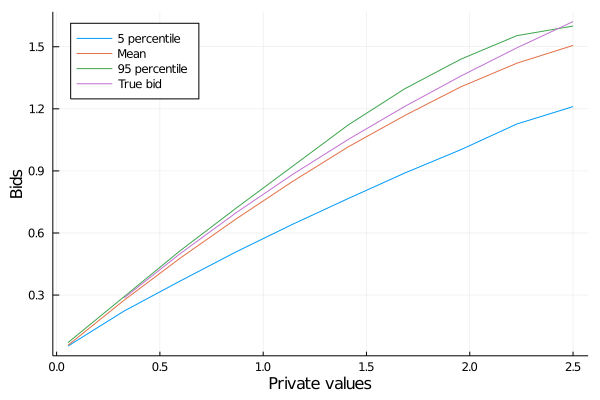

In [5]:
div = 10
v = range(0.055,2.5,length=div)[:,1]

@time results = bidsmontecarlo(1000, generateGPVbids; Kg=GPVKg)
pc5 = estimatequantiles(results,0.05)
pc95 = estimatequantiles(results,0.95)
m = mean(results,dims=1)[1,:]

plot()
plot(v,pc5, xlabel = "Private values", ylabel = "Bids", label = "5 percentile", legend = :topleft)
plot!(v,m, label = "Mean")
plot!(v,pc95, label = "95 percentile")
plot!(v,GPVbid.(v), label = "True bid")

The estimated CDF and PDFs are used to construct pseudo private values $\hat{V_{pl}}$ which requires some truncation in order to tackle the issue that $\tilde{g}$ is asymptotically biased for points close to the boundaries, where closeness is related to length of the kernel's support $\rho_g$ and bandwidth selection $h_g$. 

$$
    \hat{V}_{pl} = \begin{cases}
    B_{pl} + \frac{1}{I-1}\frac{\tilde{G}(B_{pl})}{\tilde{g}(B_{pl})} \quad \text{if} \quad B_{min}+\frac{\rho_g h_g}{2} \leq B_{pl} \leq B_{max} - \frac{\rho_g h_g}{2},\\
    \infty \quad \text{otherwise}
    \end{cases}
$$


In [6]:
function Vhatestimate(b,B,hg; ρg=2, Kg=Kg)
    Bmin = minimum(B)
    Bmax = maximum(B)
    I = size(B)[1]
    L = size(B)[2]
    inc = (Bmin + ρg*hg/2 <= b) * (b <= Bmax - ρg*hg/2)
    if inc == 1
        V = b + 1/(I-1)*Gtilde(b,B)/gtilde(b,B,hg; Kg=Kg)
    else 
        V = Inf
    end
    return V
end

Vhatestimate (generic function with 1 method)

The pseudo-sample of private values is then used to estimate the density of private values using

\begin{align}
    \tilde{f}(v) = \frac{1}{ILh_f} \underset{l=1}{\overset{L}{\sum}} \underset{p=1}{\overset{I}{\sum}} K_f(\frac{v-\hat{V}_{pl}}{h_f})
\end{align}

where kernel and bandwidth selection is similar to before with $K_f=K_g$ and $h_f = 1.06\hat{\sigma_v}(IL)^{-\frac{1}{5}}$ where $\hat{\sigma_v}$ is the estimated standard deviation of trimmed pseudo-values.

In [7]:
GPVKf(u) = 35/32 * (1-u^2)^3 * (abs(u)<=1)

function fhatestimate(v, Vhat, hf; Kf=Kf)
    f = 1/hf * mean( Kf.( (v.-Vhat) ./hf) )
    return f
end

fhatestimate (generic function with 1 method)

We now do 1000 simulations, and compare the mean, 5% percentile and 95% percentile for the estimates of the private values. 

In [8]:
function GPVfsbandwidth(B,I,L)
    σbhat = sqrt(var(B))
    hg = 1.06 * σbhat * (I*L)^(-1/5)
    return hg
end

function GPVssbandwidth(Vhat,I,L)
    trimVhat = Vhat[Vhat.<Inf]
    σvhat = sqrt(var(trimVhat))
    ILt = length(trimVhat)
    hf = 1.06 * σvhat * (ILt)^(-1/5)
end

function densityestimation(v,B,fsbandwidth,ssbandwidth,Kg,Kf)
    I = size(B)[1]
    L = size(B)[2]
    σbhat = sqrt(var(B))
    hg = fsbandwidth(B,I,L)
    Vestimate = b-> Vhatestimate(b,B,hg;Kg=Kg)
    Vhat = Vestimate.(B)
    hf = ssbandwidth(Vhat,I,L)
    festimate = v-> fhatestimate(v,Vhat,hf; Kf=Kf)
    fhat = festimate.(v)
    return fhat, hf
end
    

function densitysimulation(v,I,L, genbid, fsbandwidth, ssbandwidth, Kg, Kf)
    B = genbid(I,L)
    fhat, hf = densityestimation(v,B,fsbandwidth,ssbandwidth,Kg,Kf)
    return fhat, hf
end

function densitymontecarlo(k,genbid,fsbandwidth,ssbandwidth,Kg,Kf; v=v, I=I, L=L)
    div = length(v)
    result = zeros(div)'
    bandwidths = 0
    
    for i = 1:k
        fhat, hf = densitysimulation(v,I,L, genbid, fsbandwidth, ssbandwidth, Kg, Kf)
        result = vcat(result,fhat')
        bandwidths = vcat(bandwidths, hf)
    end
    
    result = result[2:k+1,:]
    bandwidths = bandwidths[2:k+1]
    
    return result, bandwidths
end     

densitymontecarlo (generic function with 1 method)

meanbandwidth = 0.147211174739713


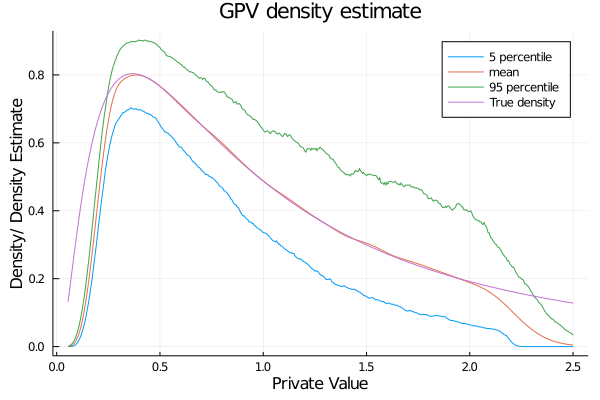

In [9]:
div = 500
v = range(0.055,2.5,length=div)[:,1]

densityresult, bandwidths = densitymontecarlo(1000,generateGPVbids,GPVfsbandwidth, GPVssbandwidth, GPVKg,GPVKf)
pc5 = estimatequantiles(densityresult,0.05)
pc95 = estimatequantiles(densityresult,0.95)
m = mean(densityresult,dims=1)[1,:]
meanbandwidth = mean(bandwidths)

@show meanbandwidth

plot(v,pc5, title = "GPV density estimate",xlabel = "Private Value", 
    ylabel = "Density/ Density Estimate", label = "5 percentile")
plot!(v,m, label = "mean")
plot!(v,pc95, label = "95 percentile")
plot!(v,f.(v), label = "True density")

We have the same result as GPV where the mean almost coincides with the true density perfectly for points far enough from the boundaries 0.055 and 2.5. 

### Results from Ma, Marmer and Shneyerov (2019)

In Ma, Marmer and Shneyerov, they assumed that bids follow a distribution characterized by the cdf

\begin{align}
    F_\theta(v) = v^\theta\cdot 1(0\leq v \leq1)
\end{align}

with pdf

\begin{align}
    f_\theta(v) = \theta v^{\theta-1} \cdot 1(0\leq v \leq1)
\end{align}


In [10]:
MMScdf(x,θ) = x^θ*(x≤1)*(x≥0)
MMSpdf(x,θ) = θ*x^(θ-1)*(x≤1)*(x≥0)
MMSquantile(x,θ) = exp(log(x)/θ)

function generateMMSvalues(I,L;θ=θ)
    U = rand(I,L)
    inversecdf = x-> MMSquantile(x,θ)
    sample = inversecdf.(U)
end

generateMMSvalues (generic function with 1 method)


The corresponding BNE bidding strategy is 

\begin{align}
    s(v) = (1-\frac{1}{\theta(I-1)+1})v
\end{align}

The special property of this specification is that the inverse bidding strategy has an analytic form

$$ \xi(b) = b + \frac{1}{I-1}\frac{G(b)}{g(b)} $$

We will define the estimated inverse bidding strategy as 


$$ \hat{\xi}(b) = b + \frac{1}{I-1}\frac{\hat{G}(b)}{\hat{g}(b)} $$

In [11]:
function MMSbid(v,θ;I=I)
    b = (1-(θ*(I-1)+1)^(-1))*v
    return b
end

function generateMMSbids(I,L;θ=θ)
    V = generateMMSvalues(I,L;θ=θ)
    f = x->MMSbid(x,θ;I=I)
    return f.(V)
end

θ = 3
generateMMSbids(5,200)

5×200 Array{Float64,2}:
 0.76522   0.51912   0.408591  0.87216   …  0.482425  0.331375  0.590099
 0.73357   0.530058  0.913646  0.635715     0.399194  0.803283  0.512335
 0.698688  0.728289  0.776287  0.917966     0.815359  0.906393  0.825007
 0.831858  0.733256  0.520722  0.69074      0.922188  0.864207  0.773668
 0.835006  0.860468  0.373158  0.83992      0.855997  0.713451  0.885036

They considered θ∈{1，2} and drew samples from $f_\theta$. In the first step, the fourth-order triweight kernel is chosen and in the second step, the second order triweight kernel is chosen. In terms of bandwidth, the first stage bandwidth is 

\begin{align}
 h_g = 3.72 \cdot \hat{\sigma_b} \cdot (IL)^{-1/5} 
\end{align}

and 
$$ h_f = 3.15 \cdot \hat{\sigma_v} \cdot ((I\cdot L)_\mathbb{T})^{-1/5}$$

where $(I\cdot L)_\mathbb{T}$ is the number of bids remaining after the trimming.

In [12]:
MMSKf(u) = 35/32 * (1-u^2)^3 * (abs(u)<=1)
MMSKg(u) = 27/16*(1-11/3*u^2)*MMSKf(u)
MMSdensity = v->MMSpdf(v,θ)

function MMSfsbandwidth(B,I,L)
    σbhat = sqrt(var(B))
    hg = 3.72 * σbhat * (I*L)^(-1/5)
    return hg
end

function MMSssbandwidth(Vhat,I,L)
    trimVhat = Vhat[Vhat.<Inf]
    σvhat = sqrt(var(trimVhat))
    ILt = length(trimVhat)
    hf = 3.15 * σvhat * (ILt)^(-1/5)
end

MMSssbandwidth (generic function with 1 method)

meanbandwidth = 0.12256029014896143


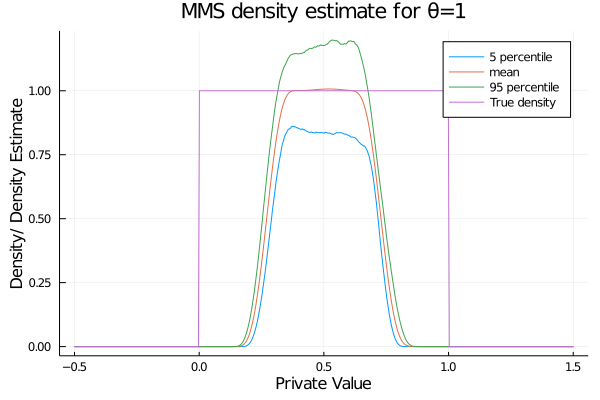

In [13]:
div = 500
v = range(-0.5,1.5,length=div)[:,1]
θ = 1

densityresult, bandwidths = densitymontecarlo(1000,generateMMSbids,MMSfsbandwidth, MMSssbandwidth, MMSKg, MMSKf)
pc5 = estimatequantiles(densityresult,0.05)
pc95 = estimatequantiles(densityresult,0.95)
m = mean(densityresult,dims=1)[1,:]
meanbandwidth = mean(bandwidths)

@show meanbandwidth

plot(v,pc5, title = "MMS density estimate for θ=1",xlabel = "Private Value", 
    ylabel = "Density/ Density Estimate", label = "5 percentile")
plot!(v,m, label = "mean")
plot!(v,pc95, label = "95 percentile")
plot!(v,MMSdensity.(v), label = "True density")

meanbandwidth = 0.13082881158889736


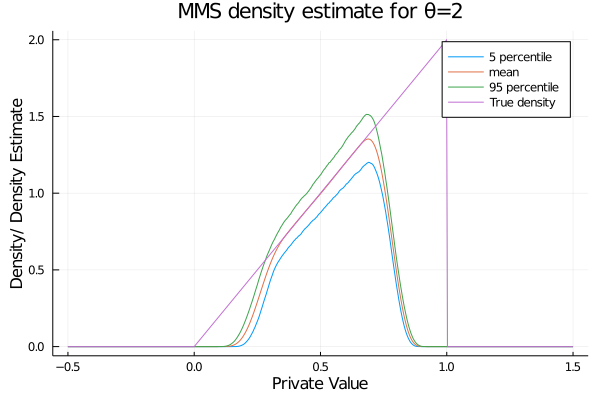

In [14]:
div = 500
v = range(-0.5,1.5,length=div)[:,1]
θ = 2

densityresult, bandwidths = densitymontecarlo(1000,generateMMSbids,MMSfsbandwidth, MMSssbandwidth, MMSKg, MMSKf)
pc5 = estimatequantiles(densityresult,0.05)
pc95 = estimatequantiles(densityresult,0.95)
m = mean(densityresult,dims=1)[1,:]
meanbandwidth = mean(bandwidths)
MMSdensity = v->MMSpdf(v,θ)
@show meanbandwidth

plot(v,pc5, title = "MMS density estimate for θ=2",xlabel = "Private Value", 
    ylabel = "Density/ Density Estimate", label = "5 percentile")
plot!(v,m, label = "mean")
plot!(v,pc95, label = "95 percentile")
plot!(v,MMSdensity.(v), label = "True density")

Again, for points away from boundary, the mean coincides nearly perfectly with the true density. Now, we look at the distribution estimates at several points that are sufficiently far from the boundaries.

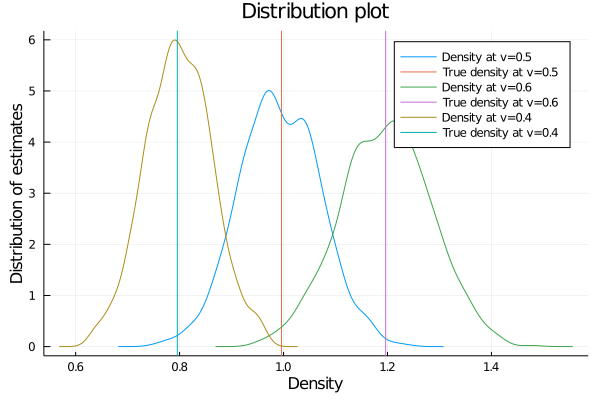

In [15]:
h1 = density(densityresult[:,250], label = "Density at v=0.5", 
    ylabel = "Distribution of estimates", xlabel = "Density", title="Distribution plot")
vline!([MMSdensity.(v)[250]], label = "True density at v=0.5")

h2 = density!(densityresult[:,275], label = "Density at v=0.6")
vline!([MMSdensity.(v)[275]], label = "True density at v=0.6")

h3 = density!(densityresult[:,225], label = "Density at v=0.4")
vline!([MMSdensity.(v)[225]], label = "True density at v=0.4")


We compute the standard errors and uniform confidence bands using the bootstrap based method proposed in MMS. The process is:

First we draw $B^*$ an $I \times L$ bootstrap sample from original B. We construct $\hat{G}^*$ and $\hat{g}^*$ which are bootstrap analogues of $\hat{G}$ and $\hat{g}$. Let $\hat{Xi}^*$ be the bootstrap analogue of  $\hat{\xi}$  defined using $\hat{G}^*$ and $\hat{g}^*$.

We then generate bootstrap samples of pseudo values as $\hat{V}^*_{il} = \hat{\xi}^*(B^*_{il})$

Finally we construct a bootstrap analogue of $\hat{f}_{GPV}(v)$:

$$ \hat{f} _{GPV} ^*(v) = \frac{1}{IL} \sum{\mathbb{T}^*_{il}}\frac{1}{h_f}K_f(\frac{\hat{V}^*_{il}-v}{h_f}) $$

where $\mathbb{T}^*_{il}=1(Bmin + h_g \leq B^*_{il} \leq Bmax-h_g)$

The percentile bootstrap CI is

$$ CI^*(v) = [\hat{f} _{GPV}(v)+\frac{s^*_\frac{\alpha}{2}(v)}{\sqrt{(Lh^3)}} , \hat{f} _{GPV}(v)+\frac{s^*_{1-\frac{\alpha}{2}}(v)}{\sqrt{(Lh^3)}}] $$

where $s^*_\tau(v)$ is the $\tau$ quantile of the conditional distribution of 

$$S^*(v) = (Lh^3)^\frac{1}{2}(\hat{f}^*_{GPV}(v)-\hat{f}_{GPV}(v))$$

We shall compute this quantity using Monte Carlo methods.

In [16]:
function Vtrim(b,Bmax,Bmin,hg)
    inc = (b<=Bmax-hg)*(b>=Bmin+hg)
    if inc == 1
        Vtrim = 1
    else
        Vtrim = 0
    end
end

function xistar(b, B, fsbandwidth; Kg = GPVKg)
    I = size(B)[1]
    Ghat = x->Gtilde(x,B)
    hg = fsbandwidth(B,I,L)
    ghat = x->gtilde(x,B,hg;Kg=Kg)
    xi = b +1/(I-1)*Ghat(b)/ghat(b)
end

function fstarestimate(v,B,fsbandwidth,ssbandwidth,Kg,Kf)
    I = size(B)[1]
    L = size(B)[2]
    Bstar = reshape(sample(B,I*L),(I,L))
    Bmax = maximum(Bstar)
    Bmin = minimum(Bstar)
    Ghatstar = x->Gtilde(x,Bstar)
    hg = fsbandwidth(Bstar,I,L)
    ghatstar = x->giltde(x,Bstar,hg;Kg = Kg)
    xihat = b->xistar(b,B,fsbandwidth)
    Vhatstar = xihat.(Bstar)
    trim = x-> Vtrim(x,Bmax,Bmin,hg)
    Bstartrim = trim.(Bstar)
    hf = ssbandwidth(Vhatstar,I,L)
    fhatstar = 1/(I*L)*(1/hf)*sum(Bstartrim.*Kf.((Vhatstar.-v)/hf))
    return fhatstar
end

fstarestimate(1.0,B,MMSfsbandwidth,MMSssbandwidth,MMSKg,MMSKf)

0.5751053420276911

In [17]:
function confidenceinterval(v,B,fsbandwidth,ssbandwidth,Kg,Kf,α; k=1000)
    fhat,h = densityestimation(v,B,fsbandwidth,ssbandwidth,Kg,Kf)
    fstardraws = 0
    for i = 1:k
        fhatstar = fstarestimate(v,B,fsbandwidth,ssbandwidth,Kg,Kf)
        fstardraws = vcat(fstardraws,fhatstar)
    end
    fstardraws = fstardraws[2:k+1]
    L = size(B)[2]
    Sstar = (L*h^3)^(1/2).*(fstardraws.-fhat)
    a = quantile(Sstar,α/2)
    b = quantile(Sstar,1-α/2)
    LB = fhat + a/sqrt(L*h^3)
    RB = fhat + b/sqrt(L*h^3)
    return LB,RB
end

confidenceinterval (generic function with 1 method)

In [18]:
θ = 2
B = generateMMSbids(5,200)
LB,RB = confidenceinterval(0.5,B,MMSfsbandwidth,MMSssbandwidth,MMSKg,MMSKf,0.05)

(0.8441978447789384, 1.0489943963807047)

Now we check the coverage probability of the confidence interval.

In [19]:
function coverageprobability(v,I,L,fsbandwidth,ssbandwidth,Kg,Kf,α;θ=θ,M=500,k= 500)
    actual = MMSdensity(v)
    check = 0
    for i = 1:M
        B = generateMMSbids(I,L)
        LB,RB = confidenceinterval(v,B,fsbandwidth,ssbandwidth,Kg,Kf,α; k=k)
        inCI = ((actual<=RB)*(actual>=LB)).*1
        check = vcat(check,inCI)
    end
    check = check[2:M+1]
    mean(check)
end

coverageprobability (generic function with 1 method)

Ideally, M and K should be large. However, on my laptop, this takes too long to run, so I am picking a smaller number for M just to demonstrate its functionality.

In [ ]:
θ = 2
@time coverageprobability(0.5,5,200,MMSfsbandwidth,MMSssbandwidth,MMSKg,MMSKf,0.05, M=20)